In [ ]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Define the ODE function
def model(y, t):
    dydt = -2 * y
    return dydt

# Initial condition
y0 = 1

# Time points where the solution is computed
t = np.linspace(0, 5, 100)

# Solve ODE
y = odeint(model, y0, t)

# Plot the results
plt.plot(t, y)
plt.xlabel('Time')
plt.ylabel('y(t)')
plt.title('Solution of dy/dt = -2y')
plt.grid(True)
plt.show()


In [73]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import interpolate
from torchdiffeq import odeint

# Dictionary of activation functions
activations = {'relu': torch.nn.ReLU(),
               'sigmoid': torch.nn.Sigmoid(),
               'elu': torch.nn.ELU(),
               'tanh': torch.nn.Tanh(),
               'gelu': torch.nn.GELU(),
               'silu': torch.nn.SiLU(),
               'softplus': torch.nn.Softplus(beta=1, threshold=20),
               'leaky_relu': torch.nn.LeakyReLU()}


class NICE_reduced(torch.nn.Module):
    '''
    Neural Integration for Constitutive Equations (NICE) - Reduced Version
    '''

    def __init__(self, params_evolution, number_IC, norm_params, dim=2, dtype=torch.float32):
        super(NICE_reduced, self).__init__()

        # Set data type and dimension
        self.dtype,self.dim = dtype , dim

        # Unpack normalization parameters
        self.prm_e, self.prm_de, self.prm_s, self.prm_dt = norm_params
        frac = 0.5; self.prm_ee = self.prm_e * frac;self.prm_dee = self.prm_de * frac

        # Initialize solver and neural networks for evolution and energy
        self.solver = None
        self.NeuralNetEvolution = self.constructor(params_evolution)#NNf_params = [2*dim,dim,[6*(2*dim),6*(2*dim),6*(2*dim),],'gelu']
        self.relu = torch.nn.ReLU()

        # Initialize elastic strain parameter and normalization factor
        self.e0 = torch.nn.Parameter(torch.zeros((number_IC, self.dim)), requires_grad=True)
        self.inference = None

    def constructor(self, params):
        i_dim, o_dim, h_dim, act = params
        dim = i_dim
        layers = torch.nn.Sequential()
        for hdim in h_dim:
            layers.append(torch.nn.Linear(dim, hdim, dtype=self.dtype))
            layers.append(activations[act])
            dim = hdim
        layers.append(torch.nn.Linear(dim, o_dim, dtype=self.dtype))
        return layers

    def Normalize(self, inputs, prm):
        return torch.divide(torch.add(inputs, -prm[1]), prm[0])

    def DeNormalize(self, outputs, prm):
        return torch.add(torch.multiply(outputs, prm[0]), prm[1])

    def forward(self, t, y):
        # Extract elastic strain and normalize
        uel = y[:, :self.dim]; nel = self.Normalize(uel, self.prm_ee)

        # Determine total strain rate (ueps_dot)
        if self.inference == False:
            if t > 1.:
                ueps_dot = self.de[-1]
            else:
                ueps_dot = self.de[int(t / self.prm_dt)]
        else:
            # Interpolate external data for inference
            ueps_dot = torch.zeros((len(self.idx), 2))
            for i in range(len(self.idx)):
                ueps_dot[i, 0] = torch.from_numpy(self.interp_dotev[self.idx[i]](t.detach().numpy()))
                ueps_dot[i, 1] = torch.from_numpy(self.interp_dotes[self.idx[i]](t.detach().numpy()))
        
        neps_dot = self.Normalize(ueps_dot, self.prm_de).detach()
        
        # Feed-forward neural network for evolution
        nodes = self.NeuralNetEvolution(torch.cat((neps_dot, nel), -1))##NNf_params = [2*dim,dim,[6*(2*dim),6*(2*dim),6*(2*dim),],'gelu']
        node_el = nodes[:, :self.dim];uode_el = self.DeNormalize(node_el, self.prm_dee)# De-normalize the output

        return uode_el

    def integrate(self, de, y0, t, idx):
        self.de = de# give stain all alomg the history path, its shape is [40, 24, 2] 40 points for each path X 24 path x strain has two comps.
        self.idx = idx
        y_ = odeint(self, y0, t, method=self.solver, options={"step_size": self.step_size})#forward(self, t, y): deps = self.de[t] (its shape is [40, 24, 2]) return NNEV(deps, e_el), -1)) with dim(:,dim=2)
        #t = tensor([0.0000, 0.0250, 0.0500, *******************,2.4750])@ number is 100
        uel = y_[:, :, :self.dim]; nel = self.Normalize(uel, self.prm_ee)

        # Calculate stress #stress = self.stress(uel)
        K = 70.e+6;G = 60.e+6;stress = torch.stack((K*uel[:,:,0], 3*G*uel[:,:,1]), dim=-1); nstress = self.Normalize(stress, self.prm_s)

        n_de = self.Normalize(self.de, self.prm_de)

        # Feed-forward neural network for evolution
        nodes = self.NeuralNetEvolution(torch.cat((n_de, nel), -1))
        node_el = nodes[:, :, :self.dim];uode_el = self.DeNormalize(node_el, self.prm_dee)

        # Calculate the dissipation rate
        uode_pl = self.de - uode_el

        return y_, stress, torch.einsum('ijk,ijk->ij', stress[1:], uode_pl[:-1])

    def init_interp(self, args, t):
        # Initialize interpolation for external data
        self.x = np.arange(args.shape[1])
        self.interp_dotev = []
        self.interp_dotes = []
        for i in range(len(self.x)):
            f = interpolate.interp1d(t, args[:, i, 0], fill_value="extrapolate", kind="previous")
            g = interpolate.interp1d(t, args[:, i, 1], fill_value="extrapolate", kind="previous")
            self.interp_dotev.append(f)
            self.interp_dotes.append(g)

    def find_elastic_strain(self, eps_e, sigma):
        # Find elastic strain using a root-finding method
        eps_e_tensor = torch.from_numpy(eps_e.reshape(-1, 2))
        #eps_e_tensor.requires_grad = True
        ueps_e_tensor = self.DeNormalize(eps_e_tensor, self.prm_ee)
        #ustress = self.stress(ueps_e_tensor)
        K = 70.e+6;G = 60.e+6;ustress = torch.stack((K*ueps_e_tensor[:,0], 3*G*ueps_e_tensor[:,1]), dim=-1)
        rhs = self.Normalize(sigma, self.prm_s).detach() - self.Normalize(ustress, self.prm_s).detach().numpy()
        return rhs.reshape(-1)

In [179]:
t

array([0. , 0.2, 0.4, 0.6, 0.8])

# Neural integration for constitutive equations 

### Benchmark #1: elasto-plastic material

Authors: Filippo Masi, Itai Einav

### 1. Import libraries

In [4]:
import pickle
import numpy as np
import torch
from scipy.optimize import root
from torchdiffeq import odeint
from nice_module import EarlyStopping, slice_data, get_params
#from nice_module import NICE_reduced
np.random.seed(6)
torch.manual_seed(6)

# plotting
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('classic')
plt.rcParams.update({"axes.grid" : False, "grid.color": 'black', "grid.alpha":0.4})
font = {'size'   : 11}
matplotlib.rc('font', **font)
plt.rcParams['axes.facecolor']='none'
plt.rcParams['savefig.facecolor']='none'
plt.rcParams['figure.facecolor']='none'
plt.rcParams["figure.figsize"] = (2.5,2)
plt.tight_layout(pad=2.5, w_pad=3.5, h_pad=3.5)
colorb = (0.2,0.4,0.7)

<Figure size 200x160 with 0 Axes>

#### 1.1 Set hyperparameters

In [135]:
# Setting the frequency in epochs for printing loss during training
verbose_frequency = 10

# Step size for the training process. If set to 20, it reproduces the original results
# otherwise, set to 1 for faster training.
step_size = 20

# Checking for GPU availability and assigning the device accordingly
#device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# Boolean flag for adding normally distributed noise to the training dataset
corrupted_training_data = False

# If corrupted_training_data is True, set the noise amplitude (percentage)
delta = 0.  # Noise amplitude (percentage) if corrupted_training_data is True

### 2. Import and prepare data sets

In [136]:
np.size(strain_tdt)

3000

In [147]:
dt

1.0

In [137]:
# File path for the training dataset
file = './dataset/benchmark1_data_training'

# Loading data from the specified file using pickle
with open(file, 'rb') as f_obj:
    data = pickle.load(f_obj)

# Unpacking data into individual variables
[strain_t,strain_tdt,stress_t,dt,n_reset] = data

# Setting batch_time equal to n_reset
batch_time = n_reset

# Setting data_size equal to n_reset
data_size = n_reset

# Dimensionality of the data
dim = 2

# Setting prm_dt as the reciprocal of data_size
prm_dt = 1 / data_size

#### 3.1 Reshape 


In [149]:
strain_tdt - strain_t

array([[ 6.16235654e-07,  9.73167719e-07],
       [ 1.96008401e-07,  1.14472478e-06],
       [-2.62575672e-07,  1.33194094e-06],
       ...,
       [-1.00000000e-06,  0.00000000e+00],
       [-1.00000000e-06,  0.00000000e+00],
       [-1.00000000e-06,  0.00000000e+00]])

In [152]:
dstrain = strain_tdt - strain_t
dstrain/=prm_dt

strain_t = np.reshape(strain_t,(batch_time,-1,dim),order='F')
strain_tdt = np.reshape(strain_tdt,(batch_time,-1,dim),order='F')
dstrain = np.reshape(dstrain,(batch_time,-1,dim),order='F')

stress_t = np.reshape(stress_t,(batch_time,-1,dim),order='F')

data_size = strain_t.shape[0]
number_IC = strain_t.shape[1]

In [153]:
strain_t.shape

(40, 24, 2)

#### 3.2 Split data in training, validation, and test sets 

In [79]:
# Percentage of data to be used for training
train_percentage = 0.65

# Calculating the number of samples for training, validation, and testing
train = int(round(number_IC * train_percentage))
val = int(round(number_IC * 0.5 * (1. - train_percentage)))
test = val

# Printing information about the data split
print("Number of samples: ", number_IC)
print("Training samples: ", train)
print("Validation samples: ", val)
print("Test samples: ", test)
print("Total: ", test + val + train)

Number of samples:  24
Training samples:  16
Validation samples:  4
Test samples:  4
Total:  24


In [154]:
# Creating an array of sequential numbers from 0 to number_IC - 1
n = np.arange(0, number_IC, 1)

# Creating an array of indices and shuffling it
rnd = np.arange(len(n))
np.random.shuffle(rnd)
n = n[rnd]

# Splitting the shuffled indices into training, validation, and test sets
ntrain = n[:train]
cut = len(ntrain)
nval = n[train:]
ntrainval = np.hstack((ntrain, nval))
ntest = n[train + val:]

# Shuffling the indices for training and validation combined set
rnd = np.arange(len(ntrainval))
np.random.shuffle(rnd)

# Splitting the shuffled indices for training and validation sets
ntrain = rnd[:train]
nval = rnd[val:]

In [81]:
ntrain

array([ 8,  1, 10, 16,  6, 13,  7, 20,  9, 23,  3, 12,  2,  0, 14, 21])

In [82]:
ntrainval

array([21,  7,  5,  6,  8,  2, 17, 16,  4, 12, 18, 11,  1, 22, 14,  0, 19,
       15, 13, 23, 20,  3,  9, 10])

In [156]:
# Slicing the strain data into training-validation and test sets
strain_t_tv, strain_t_test = slice_data(strain_t, ntrainval, ntest)

# Slicing the time derivative of strain data into training-validation and test sets
strain_tdt_tv, strain_tdt_test = slice_data(strain_tdt, ntrainval, ntest)

# Slicing the incremental strain data into training-validation and test sets
dstrain_tv, dstrain_test = slice_data(dstrain, ntrainval, ntest)

# Slicing the stress data into training-validation and test sets
stress_t_tv, stress_t_test = slice_data(stress_t, ntrainval, ntest)

In [86]:
# Checking if training data needs to be corrupted with noise
if corrupted_training_data:

    # Generating a stress noise vector
    noise = delta/100 * np.random.normal(0, 1, ((data_size+1, number_IC, dim)))
    
    # Copying the stress data to apply noise
    noise_stress_t = stress_t_tv.copy()
    
    # Adding noise to the stress data
    noise_stress_t[:, :, 0] = np.mean(stress_t_tv[:, :, 0]) * noise[:-1, :, 0]
    noise_stress_t[:, :, 1] = np.mean(stress_t_tv[:, :, 1]) * noise[:-1, :, 1]
    
    # Setting the initial time step to zero
    noise_stress_t[0] *= 0.0
    
    # Adding the noise to the original stress data
    stress_t_tv += noise_stress_t

In [87]:
prm_e = get_params(strain_t_tv).to(device)
prm_de = get_params(dstrain_tv).to(device)
prm_s = get_params(stress_t_tv).to(device)

### 4. Neural integration for constitutive equations

#### 4.1 Constructu neural net and set integration scheme

In [158]:
import torch
import argparse

# Parse command-line arguments
parser = argparse.ArgumentParser(description='Set device.')
parser.add_argument('--device', type=str, default='cpu', choices=['cpu', 'cuda'], help='Device to use (default: cpu)')
args = parser.parse_args()

# Set the device to CPU or CUDA based on the argument, but default to CPU
device = torch.device(args.device if args.device == 'cpu' or torch.cuda.is_available() else 'cpu')

# Print the device being used
print("Using device:", device)


usage: ipykernel_launcher.py [-h] [--device {cpu,cuda}]
ipykernel_launcher.py: error: unrecognized arguments: --f=c:\Users\osama\AppData\Roaming\jupyter\runtime\kernel-v2-85108LWaYs3uDU3QI.json


SystemExit: 2

c:\Users\osama\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [160]:
dtype=torch.float64
NNf_params = [2*dim+4,dim+4,[6*(2*dim),6*(2*dim),6*(2*dim),],'gelu']
#NNu_params = [2,1,[2**6,2**6],'softplus']
norm_params = [prm_e,prm_de,prm_s,prm_dt]
nsvars = 1
number_IC = len(ntrainval)
NICE_network = NICE_reduced(NNf_params,number_IC,norm_params,dim,dtype).to(device)
NICE_network.to(torch.double)

NICE_reduced(
  (NeuralNetEvolution): Sequential(
    (0): Linear(in_features=8, out_features=24, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=24, out_features=24, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=24, out_features=24, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=24, out_features=6, bias=True)
  )
  (relu): ReLU()
)

In [161]:
data_size

40

In [163]:
# Calculating the time step for the simulation
prm_dt = 1 / data_size

# Creating a time array from 0 to 1 with the calculated time step
t = torch.arange(0, 1.0, prm_dt)

# Converting stress and incremental strain data to torch tensors and moving them to the specified device
stress_tv = torch.from_numpy(np.float64(stress_t_tv)).to(device)
dstrain_tv = torch.from_numpy(np.float64(dstrain_tv)).to(device)

# Converting test set stress and incremental strain data to torch tensors and moving them to the specified device
stress_test = torch.from_numpy(np.float64(stress_t_test)).to(device)
dstrain_test = torch.from_numpy(np.float64(dstrain_test)).to(device)

In [166]:
dstrain_tv

tensor([[[ 4.0000e-05,  0.0000e+00],
         [ 0.0000e+00,  4.0000e-05],
         [ 3.0618e-05,  3.6490e-05],
         ...,
         [ 3.0330e-05,  3.6608e-05],
         [ 0.0000e+00,  4.0000e-05],
         [ 0.0000e+00,  4.0000e-05]],

        [[ 4.0000e-05,  0.0000e+00],
         [ 0.0000e+00,  4.0000e-05],
         [ 2.9599e-05,  3.6906e-05],
         ...,
         [ 2.8673e-05,  3.7284e-05],
         [ 0.0000e+00,  4.0000e-05],
         [ 0.0000e+00,  4.0000e-05]],

        [[ 4.0000e-05,  0.0000e+00],
         [ 0.0000e+00,  4.0000e-05],
         [ 2.8518e-05,  3.7347e-05],
         ...,
         [ 2.6868e-05,  3.8021e-05],
         [ 0.0000e+00,  4.0000e-05],
         [ 0.0000e+00,  4.0000e-05]],

        ...,

        [[-4.0000e-05,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00],
         [-3.1106e-05, -3.6291e-05],
         ...,
         [-3.1106e-05, -3.6291e-05],
         [ 0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00]],

        [[-4.0000e-05,  0.0000e+00

In [111]:
t

tensor([0.0000, 0.0500, 0.1000, 0.1500, 0.2000, 0.2500, 0.3000, 0.3500, 0.4000,
        0.4500, 0.5000, 0.5500, 0.6000, 0.6500, 0.7000, 0.7500, 0.8000, 0.8500,
        0.9000, 0.9500])

In [92]:
# Setting the solver type for the NICE network
NICE_network.solver = "midpoint"

# Setting the integration scheme for the NICE network
NICE_network.scheme = "forward"

# Setting the step size for the integration in the NICE network
NICE_network.step_size = prm_dt / step_size

# Initializing the interpolation function for incremental strain and time in the NICE network
NICE_network.init_interp(dstrain_tv, t)

# Turning off the inference mode in the NICE network
NICE_network.inference = False

In [173]:
import numpy as np
from scipy import interpolate

# Example data
t = np.array([0, 0.2, 0.4, 0.6, 0.8])  # Time points
args = np.array([
    [[1, 10], [2, 20], [3, 30]],  # Values at t=0
    [[4, 40], [5, 50], [6, 60]],  # Values at t=0.2
    [[7, 70], [8, 80], [9, 90]],  # Values at t=0.4
    [[10, 100], [11, 110], [12, 120]],  # Values at t=0.6
    [[13, 130], [14, 140], [15, 150]],  # Values at t=0.8
])

class Interpolator:
    def init_interp(self, args, t):
        # Initialize interpolation for external data
        self.x = np.arange(args.shape[1])
        self.interp_dotev = []
        self.interp_dotes = []
        for i in range(len(self.x)):
            f = interpolate.interp1d(t, args[:, i, 0], fill_value="extrapolate", kind="previous")
            g = interpolate.interp1d(t, args[:, i, 1], fill_value="extrapolate", kind="previous")
            self.interp_dotev.append(f)
            self.interp_dotes.append(g)

# Create an instance and initialize interpolation
interp = Interpolator()
interp.init_interp(args, t)

# Interpolation functions for the first data series
f0 = interp.interp_dotev[2]  # Interpolation function for args[:, 2, 0]
g0 = interp.interp_dotes[2]  # Interpolation function for args[:, 2, 1]

# Interpolate at t=0.5
print(f0(0.5))  # Should print the value of args[:, 0, 0] at t=0.5
print(g0(0.5))  # Should print the value of args[:, 0, 1] at t=0.5


9.0
90.0


#### 4.2 Training

In [93]:
# Setting the learning rate for the optimizer
learningRate = 1e-2

# Initializing the Adam optimizer with the NICE network parameters
optimizer = torch.optim.Adam(NICE_network.parameters(), lr=learningRate)

# Setting up a learning rate scheduler to adjust the learning rate during training
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)

# L2 penalty weight for regularization
w_reg = 1.e-5

# Number of training epochs
Nepochs = 1000000

# Mean Squared Error (MSE) loss function
MSE = torch.nn.MSELoss()

# Setting up early stopping with specified criteria
checkpoint_path = './checkpoints/checkpoint.pt'
early_stopping = EarlyStopping(patience=2000, delta=1.e-9, verbose=False, path=checkpoint_path)

# Lists for storing training and validation loss history
training_loss_hist = []
validation_loss_value_hist = []

import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import interpolate
from torchdiffeq import odeint

# Dictionary of activation functions
activations = {'relu': torch.nn.ReLU(),
               'sigmoid': torch.nn.Sigmoid(),
               'elu': torch.nn.ELU(),
               'tanh': torch.nn.Tanh(),
               'gelu': torch.nn.GELU(),
               'silu': torch.nn.SiLU(),
               'softplus': torch.nn.Softplus(beta=1, threshold=20),
               'leaky_relu': torch.nn.LeakyReLU()}


class NICE_reduced(torch.nn.Module):
    '''
    Neural Integration for Constitutive Equations (NICE) - Reduced Version
    '''

    def __init__(self, params_evolution, params_energy, number_IC, norm_params, dim=2, dtype=torch.float32):
        super(NICE_reduced, self).__init__()

        # Set data type and dimension
        self.dtype,self.dim = dtype , dim

        # Unpack normalization parameters
        self.prm_e, self.prm_de, self.prm_s, self.prm_dt = norm_params
        frac = 0.5; self.prm_ee = self.prm_e * frac;self.prm_dee = self.prm_de * frac

        # Initialize solver and neural networks for evolution and energy
        self.solver = None
        self.NeuralNetEvolution = self.constructor(params_evolution)#NNf_params = [2*dim,dim,[6*(2*dim),6*(2*dim),6*(2*dim),],'gelu']
        #self.NeuralNetEnergy = self.constructor(params_energy)     #NNu_params = [2,1,[2**6,2**6],'softplus']
        self.relu = torch.nn.ReLU()

        # Initialize elastic strain parameter and normalization factor
        self.e0 = torch.nn.Parameter(torch.zeros((number_IC, self.dim)), requires_grad=True)
        #self.prm_u = np.linalg.norm(self.prm_s.cpu(), axis=1) * np.linalg.norm(self.prm_e.cpu(), axis=1)
        self.inference = None

    def constructor(self, params):
        i_dim, o_dim, h_dim, act = params
        dim = i_dim
        layers = torch.nn.Sequential()
        for hdim in h_dim:
            layers.append(torch.nn.Linear(dim, hdim, dtype=self.dtype))
            layers.append(activations[act])
            dim = hdim
        layers.append(torch.nn.Linear(dim, o_dim, dtype=self.dtype))
        return layers

    def Normalize(self, inputs, prm):
        return torch.divide(torch.add(inputs, -prm[1]), prm[0])

    def DeNormalize(self, outputs, prm):
        return torch.add(torch.multiply(outputs, prm[0]), prm[1])

    def forward(self, t, y):
        # Extract elastic strain and normalize
        uel = y[:, :self.dim]; nel = self.Normalize(uel, self.prm_ee)

        # Determine total strain rate (ueps_dot)
        if self.inference == False:
            if t > 1.:
                ueps_dot = self.eps_dot[-1]
            else:
                ueps_dot = self.eps_dot[int(t / self.prm_dt)]
        else:
            # Interpolate external data for inference
            ueps_dot = torch.zeros((len(self.idx), 2))
            for i in range(len(self.idx)):
                ueps_dot[i, 0] = torch.from_numpy(self.interp_dotev[self.idx[i]](t.detach().numpy()))
                ueps_dot[i, 1] = torch.from_numpy(self.interp_dotes[self.idx[i]](t.detach().numpy()))
        
        neps_dot = self.Normalize(ueps_dot, self.prm_de).detach()
        
        # Feed-forward neural network for evolution
        nodes = self.NeuralNetEvolution(torch.cat((neps_dot, nel), -1))##NNf_params = [2*dim,dim,[6*(2*dim),6*(2*dim),6*(2*dim),],'gelu']
        node_el = nodes[:, :self.dim];uode_el = self.DeNormalize(node_el, self.prm_dee)# De-normalize the output

        return uode_el

    def integrate(self, de, y0, t, idx):
        # Integrate the ODE using torchdiffeq
        self.eps_dot = de# give stain all alomg the history path, its shape is [40, 24, 2] 40 points for each path X 24 path x strain has two comps.
        self.idx = idx
        y_ = odeint(self, y0, t, method=self.solver, options={"step_size": self.step_size})#forward(self, t, y): deps = self.de[t] (its shape is [40, 24, 2]) return NNEV(deps, e_el), -1)) with dim(:,dim=2)
        #t = tensor([0.0000, 0.0250, 0.0500, *******************,2.4750])@ number is 100
        # Extract normalized variables
        uel = y_[:, :, :self.dim]; nel = self.Normalize(uel, self.prm_ee)

        # Calculate stress #stress = self.stress(uel)
        K = 70.e+6;G = 60.e+6;       stress = torch.stack((K*uel[:,:,0], 3*G*uel[:,:,1]), dim=-1); nstress = self.Normalize(stress, self.prm_s)

        neps_dot = self.Normalize(self.eps_dot, self.prm_de)

        # Feed-forward neural network for evolution
        nodes = self.NeuralNetEvolution(torch.cat((neps_dot, nel), -1))
        node_el = nodes[:, :, :self.dim];uode_el = self.DeNormalize(node_el, self.prm_dee)

        # Calculate the dissipation rate
        uode_pl = self.eps_dot - uode_el
        sijdepij = torch.einsum('ijk,ijk->ij', stress[1:], uode_pl[:-1])

        return y_, stress, sijdepij

    def init_interp(self, args, t):
        # Initialize interpolation for external data
        self.x = np.arange(args.shape[1])
        self.interp_dotev = []
        self.interp_dotes = []
        for i in range(len(self.x)):
            f = interpolate.interp1d(t, args[:, i, 0], fill_value="extrapolate", kind="previous")
            g = interpolate.interp1d(t, args[:, i, 1], fill_value="extrapolate", kind="previous")
            self.interp_dotev.append(f)
            self.interp_dotes.append(g)

    def find_elastic_strain(self, eps_e, sigma):
        # Find elastic strain using a root-finding method
        eps_e_tensor = torch.from_numpy(eps_e.reshape(-1, 2))
        eps_e_tensor.requires_grad = True
        ueps_e_tensor = self.DeNormalize(eps_e_tensor, self.prm_ee)
        #ustress = self.stress(ueps_e_tensor)
        K = 70.e+6;G = 60.e+6;ustress = torch.stack((K*ueps_e_tensor[:,:,0], 3*G*ueps_e_tensor[:,:,1]), dim=-1)
        rhs = self.Normalize(sigma, self.prm_s).detach() - self.Normalize(ustress, self.prm_s).detach().numpy()
        return rhs.reshape(-1)

In [174]:
# Training loop
for epoch in range(1, Nepochs):
    # Reset gradients
    optimizer.zero_grad()

    # Compute the residual of the initial stress value based on the initial elastic strain value (hyperparameter)
    ueps_e_0 = NICE_network.DeNormalize(NICE_network.e0, NICE_network.prm_ee)
    K = 70.e+6;G = 60.e+6;stress0 = torch.stack((K*ueps_e_0[:,0], 3*G*ueps_e_0[:,1]), dim=-1)
    #stress0 = NICE_network.stress(ueps_e_0)

    # Make predictions
    pred_svars, pred_stress, pred_diss = NICE_network.integrate(dstrain_tv, ueps_e_0, t, np.hstack((ntrain, nval)))

    # Compute training loss
    training_loss_stress = MSE(NICE_network.Normalize(pred_stress[:, ntrain], prm_s),
                               NICE_network.Normalize(stress_tv[:, ntrain], prm_s))
    training_loss_r0 = MSE(NICE_network.Normalize(stress0, prm_s),
                           NICE_network.Normalize(stress_tv[0], prm_s))
    norm_d = torch.max(torch.abs(pred_diss)).detach()
    training_loss_dissipation = MSE(NICE_network.relu(-pred_diss[:, ntrain]) / norm_d,
                                    pred_diss[:, ntrain].detach() * 0)

    # L2 regularization term
    l_reg = torch.tensor(0., requires_grad=True)
    for name, param in NICE_network.named_parameters():
        if 'weight' in name:
            l_reg = l_reg + pow(param, 2).sum()

    # Compute the overall training loss
    training_loss = (torch.mean(training_loss_stress)
                     + torch.mean(training_loss_r0)
                     + torch.mean(training_loss_dissipation)
                     + w_reg * l_reg
                     )

    # Backpropagate loss and perform optimizer step
    training_loss.backward()
    optimizer.step()

    # Learning rate scheduler step
    if scheduler.get_last_lr()[0] > 1.e-4:
        scheduler.step()

    # Compute validation loss
    validation_loss_stress = MSE(NICE_network.Normalize(pred_stress[:, nval], prm_s),
                                 NICE_network.Normalize(stress_tv[:, nval], prm_s))
    validation_loss_dissipation = MSE(NICE_network.relu(-pred_diss[:, nval]) / norm_d,
                                      pred_diss[:, nval].detach() * 0)
    validation_loss = torch.mean(validation_loss_stress) + torch.mean(validation_loss_dissipation)

    # Store loss values
    training_loss_value = training_loss.item()
    validation_loss_value = validation_loss.item()
    training_loss_hist.append(training_loss_value)
    validation_loss_value_hist.append(validation_loss_value)

    # Print loss information
    if not epoch % verbose_frequency:
        print(f"Epoch: {epoch}"
              + f" | training loss: {training_loss_value:.4e}"
              + f" | validation loss: {validation_loss_value:.4e}")

    # Check for early stopping criterion
    early_stopping(validation_loss_value, NICE_network)
    if early_stopping.early_stop:
        print("Early stopping")
        NICE_network.load_state_dict(torch.load(checkpoint_path))
        break

AttributeError: 'NICE_reduced' object has no attribute 'step_size'

#### 4.3 Training and validation set evaluation

In [95]:
# Define time array for evaluation
t = prm_dt * torch.linspace(0., data_size - 1, data_size).to(device)

# Get the number of initial conditions
number_IC = stress_tv.shape[1]

# Find initial elastic strain using root finding
initial_elastic_strain = root(NICE_network.find_elastic_strain,
                              args=(stress_tv[0].reshape(-1, 2)),
                              x0=np.zeros((24, 2)),
                              tol=1e-12)

# Convert the result to a torch tensor
eps_e_0 = torch.from_numpy(initial_elastic_strain.x.reshape(-1, 2))

# De-normalize the initial elastic strain
ueps_e_0 = NICE_network.DeNormalize(eps_e_0, NICE_network.prm_ee)

# Inference mode: make predictions
pred_svars, pred_stress, pred_diss = NICE_network.integrate(dstrain_tv, ueps_e_0, t, np.hstack((ntrain, nval)))

# Evaluate the Mean Absolute Error (MAE) for stress
loss = torch.nn.L1Loss()
MAE_stress = loss(NICE_network.Normalize(pred_stress, prm_s), NICE_network.Normalize(stress_tv[:, :, :dim], prm_s))

# Print the MAE for stress
print("MAE stress: ", MAE_stress)

MAE stress:  tensor(0.0113, dtype=torch.float64, grad_fn=<MeanBackward0>)


#### 4.4 Test set evaluation

In [96]:
# Get the number of initial conditions for the test set
number_IC = stress_test.shape[1]

# Define time array for evaluation
t = prm_dt * torch.linspace(0., data_size - 1, data_size).to(device)

# Initialize interpolation for the test set
NICE_network.init_interp(dstrain_test, t)

# Find initial elastic strain using root finding
initial_elastic_strain = root(NICE_network.find_elastic_strain,
                              args=(stress_test[0].reshape(-1, 2)),
                              x0=np.zeros((number_IC, 2)),
                              tol=1e-12)

# Convert the result to a torch tensor
eps_e_0 = torch.from_numpy(initial_elastic_strain.x.reshape(-1, 2))

# De-normalize the initial elastic strain
ueps_e_0 = NICE_network.DeNormalize(eps_e_0, NICE_network.prm_ee)

# Create an array for the number of initial conditions in the test set
Ntest = np.arange(0, dstrain_test.shape[1])

# Inference mode: make predictions
NICE_network.inference = True
pred_svars, pred_stress, pred_diss = NICE_network.integrate(dstrain_test, ueps_e_0, t, Ntest)

# Evaluate the Mean Absolute Error (MAE) for stress
MAE_stress = loss(NICE_network.Normalize(pred_stress, prm_s), NICE_network.Normalize(stress_test[:, :, :dim], prm_s))

# Print the MAE for stress
print("MAE stress: ", MAE_stress)

MAE stress:  tensor(0.0099, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [ ]:
#MAE stress:  tensor(0.0048, dtype=torch.float64, grad_fn=<MeanBackward0>)

### 5. Inference

In [97]:
# File path for the inference dataset
file = './dataset/benchmark1_data_inference_DrainedTriaxial'
# file = '../CModel/reference_data/DP_DT_rec6'#DP_CyDTp_recall'

# Loading data from the specified file using pickle
with open(file, 'rb') as f_obj:
    data = pickle.load(f_obj)

# Unpacking data into individual variables
[stress_t, strain_t, svars_e_t, svars_p_t,
 stress_tdt, strain_tdt, svars_e_tdt, svars_p_tdt, _, _, dt, n_reset] = data

# Setting batch_time and data_size based on the values from the inference dataset
batch_time = n_reset
data_size = n_reset

In [98]:
# Computing the incremental stress, strain, and elastic state variables
dstress = stress_tdt - stress_t
dstrain = strain_tdt - strain_t
dsvars_e = svars_e_tdt - svars_e_t

# Scaling the incremental stress, strain, and elastic state variables by the time step
dstress /= prm_dt
dstrain /= prm_dt
dsvars_e /= prm_dt

In [99]:
# Reshaping strain, incremental strain, elastic strain, and stress data arrays for better organization
strain_t = np.reshape(strain_t, (batch_time, -1, dim), order='F')
dstrain = np.reshape(dstrain, (batch_time, -1, dim), order='F')
el_strain_t = np.reshape(svars_e_t, (batch_time, -1, dim), order='F')
stress_t = np.reshape(stress_t, (batch_time, -1, dim), order='F')

# Updating data_size based on the reshaped strain_t array
data_size = strain_t.shape[0]

# Calculating the number of initial conditions
number_IC = strain_t.shape[1]

In [100]:
# Set NICE network to inference mode
NICE_network.inference = True

# Create a time array for inference
t = torch.arange(0, prm_dt * data_size, prm_dt)

# Concatenate stress and elastic strain for input data
y = torch.cat((torch.from_numpy(np.float64(stress_t)), torch.from_numpy(np.float64(el_strain_t))), -1).to(device)

# Convert incremental strain and stress to torch tensors and move to the specified device
arg = torch.from_numpy(np.float64(dstrain)).to(device)
sigma = torch.from_numpy(np.float64(stress_t)).to(device)

In [101]:
# Initialize interpolation for incremental strain and time
NICE_network.init_interp(arg, t)

# Create an array of indices
idx = np.arange(0, arg.shape[1])

# Find initial elastic strain using root finding
sol = root(NICE_network.find_elastic_strain, args=(sigma[0].reshape(-1, 2)),
           x0=np.zeros((number_IC, dim)),
           tol=1e-12)

# Convert the result to a torch tensor
eps_e_0 = torch.from_numpy(sol.x.reshape(-1, 2))

# De-normalize the initial elastic strain
ueps_e_0 = NICE_network.DeNormalize(eps_e_0, NICE_network.prm_ee)

# Inference mode: make predictions
pred_svars, pred_stress, pred_diss = NICE_network.integrate(arg[:], ueps_e_0, t[:], idx)

# Convert predictions to NumPy arrays
pred_svars = pred_svars.cpu().detach().numpy()
pred_stress = pred_stress.cpu().detach().numpy()
pred_diss = pred_diss.cpu().detach().numpy()

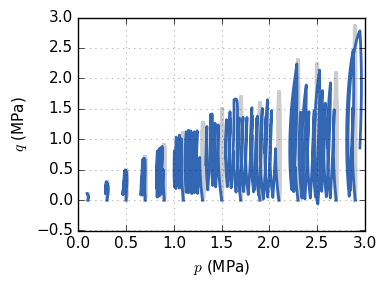

In [102]:
# Create a figure for the plot
fig = plt.figure(dpi=100, figsize=(4, 3.), tight_layout=True)

# Create a subplot
ax = fig.subplots(1)

# Plot reference stress points
for i in np.arange(sigma.shape[1]):
    ax.plot(y[:, i, 0].cpu().detach() / 1e+3, y[:, i, 1].cpu().detach() / 1e+3,
            marker='o', markerfacecolor='white', linestyle='-',
            color='black', alpha=0.2, linewidth=3, markersize=0, label='ref')

# Plot predicted stress points
for i in np.arange(pred_stress.shape[1]):
    ax.plot(pred_stress[:, i, 0] / 1e+3, pred_stress[:, i, 1] / 1e+3, alpha=1, linewidth=2, color=colorb,
            markersize=0, markeredgewidth=0.0, marker='.')

# Set labels and grid
ax.set_ylabel('$q$ (MPa)')
ax.set_xlabel('$p$ (MPa)')
ax.grid()
plt.show()

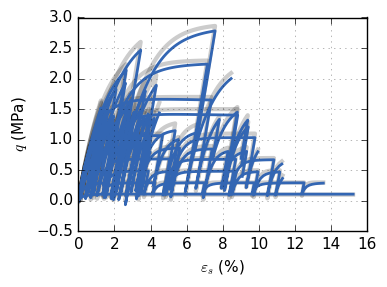

In [103]:
# Create a figure for the plot
fig = plt.figure(dpi=100, figsize=(4, 3.), tight_layout=True)

# Create a subplot
ax = fig.subplots(1)

# Plot reference stress points against strain
for i in np.arange(sigma.shape[1]):
    ax.plot(strain_t[:, i, 1] * 1e+5, y[:, i, 1].cpu().detach() / 1e+3,
            marker='o', markerfacecolor='white', linestyle='-',
            color='black', alpha=0.2, linewidth=3, markersize=0, label='ref')

# Plot predicted stress points against strain
for i in np.arange(pred_stress.shape[1]):
    ax.plot(strain_t[:, i, 1] * 1e+5, pred_stress[:, i, 1] / 1e+3, alpha=1, linewidth=2, color=colorb,
            markersize=0, markeredgewidth=0.0, marker='.')

# Set labels and grid
ax.set_ylabel('$q$ (MPa)')
ax.set_xlabel('$\\varepsilon_s$ (%)')
ax.grid()
plt.show()

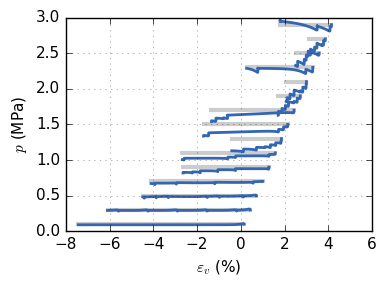

In [104]:
# Create a figure for the plot
fig = plt.figure(dpi=100, figsize=(4, 3.), tight_layout=True)

# Create a subplot
ax = fig.subplots(1)

# Plot reference stress points against volumetric strain
for i in np.arange(sigma.shape[1]):
    ax.plot(strain_t[:, i, 0] * 1e+5, y[:, i, 0].cpu().detach() / 1e+3,
            marker='o', markerfacecolor='white', linestyle='-',
            color='black', alpha=0.2, linewidth=3, markersize=0, label='ref')

# Plot predicted stress points against volumetric strain
for i in np.arange(pred_stress.shape[1]):
    ax.plot(strain_t[:, i, 0] * 1e+5, pred_stress[:, i, 0] / 1e+3, alpha=1, linewidth=2, color=colorb,
            markersize=0, markeredgewidth=0.0, marker='.')

# Set labels and grid
ax.set_ylabel('$p$ (MPa)')
ax.set_xlabel('$\\varepsilon_v$ (%)')
ax.grid()
plt.show()

### 6. Save model

In [105]:
# Define the path for saving the NICE network state dictionary
PATH = './saved/[state]NICE_benchmark1'

# Save the state dictionary of the NICE network
torch.save(NICE_network.state_dict(), PATH)

In [106]:
# Define the path for saving the normalization parameters
params_path = './saved/[params]NICE_benchmark1'

# Save the normalization parameters using pickle
with open(params_path, 'wb') as f_obj:
    pickle.dump(norm_params, f_obj)

In [112]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import interpolate
from torchdiffeq import odeint

# Dictionary of activation functions
activations = {'relu': torch.nn.ReLU(),
               'sigmoid': torch.nn.Sigmoid(),
               'elu': torch.nn.ELU(),
               'tanh': torch.nn.Tanh(),
               'gelu': torch.nn.GELU(),
               'silu': torch.nn.SiLU(),
               'softplus': torch.nn.Softplus(beta=1, threshold=20),
               'leaky_relu': torch.nn.LeakyReLU()}


class NICE_reduced2(torch.nn.Module):
    '''
    Neural Integration for Constitutive Equations (NICE) - Reduced Version
    '''

    def __init__(self, params_evolution, number_IC, norm_params, dim, dtype=torch.float32):
        super(NICE_reduced2, self).__init__()
        self.dtype,self.dim = dtype , dim; self.v_dim=dim+4
        self.prm_de,self.prm_var, self.prm_dt = norm_params
        self.solver = None
        self.NeuralNetEvolution = self.constructor(params_evolution)
        self.relu = torch.nn.ReLU()
        self.inference = None

    def constructor(self, params):
        i_dim, o_dim, h_dim, act = params;dim = i_dim
        layers = torch.nn.Sequential()
        for hdim in h_dim:
            layers.append(torch.nn.Linear(dim, hdim, dtype=self.dtype));layers.append(activations[act]);dim = hdim
        layers.append(torch.nn.Linear(dim, o_dim, dtype=self.dtype))
        return layers

    def Normalize(self, inputs, prm):
        return torch.divide(torch.add(inputs, -prm[1]), prm[0])

    def DeNormalize(self, outputs, prm):
        return torch.add(torch.multiply(outputs, prm[0]), prm[1])

    def forward(self, t, uel_k):
        nel_k = self.Normalize(uel_k, self.prm_var)#uel_k = uel_k[:, :self.v_dim]; 
        # Determine total strain rate (ueps_dot)
        if self.inference == False:
            if t > 1.:
                ueps_dot = self.de[-1]
            else:
                ueps_dot = self.de[int(t / self.prm_dt)]
        else:
            # Interpolate external data for inference
            ueps_dot = torch.zeros((len(self.idx), 2))
            for i in range(len(self.idx)):
                ueps_dot[i, 0] = torch.from_numpy(self.interp_dotev[self.idx[i]](t.detach().numpy()))
                ueps_dot[i, 1] = torch.from_numpy(self.interp_dotes[self.idx[i]](t.detach().numpy()))

        neps_dot = self.Normalize(ueps_dot, self.prm_de).detach()
        #nodes = self.NeuralNetEvolution(torch.cat((neps_dot, nel_k), -1));node_el_k = nodes[:, :self.v_dim];
        node_el_k = self.NeuralNetEvolution(torch.cat((neps_dot, nel_k), -1))
        uode_el_k = self.DeNormalize(node_el_k, self.prm_var)# De-normalize the output
        return uode_el_k

    def integrate(self, de, y0, t, idx):
        self.de = de# give stain all alomg the history path, its shape is [40, 24, 2] 40 points for each path X 24 path x strain has two comps.
        self.idx = idx
        #y_ = odeint(self, y0, t, method=self.solver, options={"step_size": self.step_size})#forward(self, t, y): deps = self.de[t] (its shape is [40, 24, 2]) return NNEV(deps, e_el), -1)) with dim(:,dim=2)
        #t = tensor([0.0000, 0.0250, 0.0500, *******************,2.4750])@ number is 100
        #uel_k = y_[:, :, :self.v_dim]; 

        uel_k = odeint(self, y0, t, method=self.solver, options={"step_size": self.step_size})#forward(self, t, y): deps = self.de[t] (its shape is [40, 24, 2]) return NNEV(deps, e_el), -1)) with dim(:,dim=2)
        nel_k = self.Normalize(uel_k, self.prm_var);nel=nel_k[:, :, :3]#cheeeeeeeeeeeeeeeeeeeeek
        n_de = self.Normalize(self.de, self.prm_de)
        # Feed-forward neural network for evolution
        node_el_k = self.NeuralNetEvolution(torch.cat((n_de, uel_k), -1))#node_el_k = nodes[:, :, :self.v_dim];
        uode_el_k = self.DeNormalize(node_el_k, self.prm_var)

        # Calculate the dissipation rate
        uode_pl = self.de - uode_el_k[:,:,:3]#cheeeeeeeeeeeeeeeeeeeeek%%%%%%%%%%%%elastic strain part

        return uel_k, torch.einsum('ijk,ijk->ij', nel[1:], uode_pl[:-1])#check dissipation

    def init_interp(self, args, t):
        # Initialize interpolation for external data
        self.x = np.arange(args.shape[1])
        self.interp_dotev = []
        self.interp_dotes = []
        for i in range(len(self.x)):
            f = interpolate.interp1d(t, args[:, i, 0], fill_value="extrapolate", kind="previous")
            g = interpolate.interp1d(t, args[:, i, 1], fill_value="extrapolate", kind="previous")
            self.interp_dotev.append(f)
            self.interp_dotes.append(g)

    def find_elastic_strain(self, eps_e, eps_e1):
        # Find elastic strain using a root-finding method
        rhs = eps_e.detach() - eps_e1.detach().numpy()
        return rhs.reshape(-1)

In [140]:
import scipy.io
import pickle

# Load the .mat file
mat_data = scipy.io.loadmat(r'C:\Users\osama\OneDrive\Desktop\conc_NICE.mat')

# Extract the variables from the .mat file
stress = mat_data['stress'];elast_e = mat_data['elast_e'];kappa_damage_t = mat_data['kappa_damage_t']#start of path
#initial
elast_e = mat_data['elast_e']
#increment
de_i = mat_data['de_i'];dstrain1=de_i
#final
stress_dt_f = mat_data['stress_dt_f'];kappa_damage_dt1 = mat_data['kappa_damage_dt'];elast_e_f = mat_data['elast_e_f']#or
energy = mat_data['energy'];disipat = mat_data['disipat']

In [116]:
extracted_array = np.empty((210, 20, 20, 4))
for i in range(210):
    for j in range(20):
        for k in range(20):
            extracted_array[i, j, k, 0] = kappa_damage_dt[i, j, k, 0, 0, 0]
            extracted_array[i, j, k, 1] = kappa_damage_dt[i, j, k, 1, 0, 0]
            extracted_array[i, j, k, 2] = kappa_damage_dt[i, j, k, 2, 0, 0]
            extracted_array[i, j, k, 3] = kappa_damage_dt[i, j, k, 3, 0, 0]
kappa_damage_dt1=extracted_array


extracted_array2 = np.empty((210, 20, 20, 3))
for i in range(210):
    for j in range(20):
        for k in range(20):
            extracted_array2[i, j, k, 0] = de_i[i, j, k, 0, 0, 0]
            extracted_array2[i, j, k, 1] = de_i[i, j, k, 1, 0, 0]
            extracted_array2[i, j, k, 2] = de_i[i, j, k, 2, 0, 0]
# Verify the shape of the resulting array
print(extracted_array2.shape)
dstrain1=extracted_array2

IndexError: too many indices for array: array is 4-dimensional, but 6 were indexed

In [40]:
import numpy as np

# Example matrix of shape (3, 2, 2)
data = np.array([[[ 1,  2],
                  [ 3,  4]],

                 [[ 5,  6],
                  [ 7,  8]],

                 [[ 9, 10],
                  [11, 12]]])

# Step 1: Transpose the dimensions to bring the desired shape
# We want to switch the first two dimensions
data_transposed = np.transpose(data, (1, 0, 2))

# Verify the intermediate shape
print("Transposed shape:", data_transposed.shape)  # Should output (2, 3, 2)

# Step 2: Reshape if needed (in this case, transpose gives the desired shape)
# Verify the final shape
print("Final shape:", data_transposed.shape)  # Should output (2, 3, 2)

# Print the final reshaped array
print(data_transposed)


Transposed shape: (2, 3, 2)
Final shape: (2, 3, 2)
[[[ 1  2]
  [ 5  6]
  [ 9 10]]

 [[ 3  4]
  [ 7  8]
  [11 12]]]


In [107]:
np.max(de_i)

3847.828861387937

In [141]:
# Reshape and compress the data
#dstrain1 = extracted_array2.reshape(-1,3)
#elast_e = elast_e.reshape(-1,3)

#kappa_damage_dt = extracted_array.reshape(-1,4)
#elast_e_f = elast_e_f.reshape(-1,3)
print('dstrain shape:', dstrain1.shape)
print('elastic_e_f shape:', elast_e_f.shape)
print('kappa_damage_dt shape:', kappa_damage_dt1.shape)
print('elast_e_i shape:', elast_e.shape)

dstrain shape: (30, 12, 20, 3)
elastic_e_f shape: (30, 12, 20, 3)
kappa_damage_dt shape: (30, 12, 20, 4)
elast_e_i shape: (30, 3)


In [142]:
e_el_kvar_t1=np.concatenate((elast_e_f, kappa_damage_dt1), axis=-1);
print('e_el_kvar_t1 shape:', e_el_kvar_t1.shape)
n_reset=20;dt=1.0

e_el_kvar_t1 shape: (30, 12, 20, 7)


In [143]:
verbose_frequency = 10# Setting the frequency in epochs for printing loss during training
# Step size for the training process. If set to 20, it reproduces the original results otherwise, set to 1 for faster training.
step_size = 20
device = torch.device('cpu')
corrupted_training_data = False# Boolean flag for adding normally distributed noise to the training dataset

batch_time = n_reset# Setting batch_time equal to n_reset
data_size = n_reset# Setting data_size equal to n_reset
dim = 3# Dimensionality of the data
prm_dt = 1 / data_size# Setting prm_dt as the reciprocal of data_size

dstrain1/=prm_dt


#dstrain1 dim 210 x 20 x (20) x 3 I need it (20) x (210*20) x 3
dstrain2 = np.transpose(dstrain1, (2, 0, 1, 3))
dstrain = np.reshape(dstrain2, (batch_time, -1, dim))
e_el_kvar_t2 = np.transpose(e_el_kvar_t1, (2, 0, 1, 3))
e_el_kvar_t = np.reshape(e_el_kvar_t2, (batch_time, -1, dim+4))

data_size = dstrain.shape[0]
number_IC = dstrain.shape[1]

In [44]:
dstrain1

array([[[[-6.03615611e-04,  1.08650810e-04,  1.08650810e-04],
         [-2.48969631e-03,  4.33733038e-04,  4.33733038e-04],
         [-3.54374451e-03,  6.12706925e-04,  6.12706925e-04],
         ...,
         [-5.97180847e-04,  9.53273434e-05,  9.53273434e-05],
         [-1.44225413e-03,  2.51783605e-04,  2.51783605e-04],
         [-1.35909493e-03,  2.43838486e-04,  2.43838486e-04]],

        [[ 1.88836522e-02, -1.81154339e-03, -1.81154339e-03],
         [-3.91808132e-03,  5.78944758e-04,  5.78944758e-04],
         [-4.70928711e-03,  7.57262821e-04,  7.57262821e-04],
         ...,
         [ 2.44288818e-04,  1.18821710e-04,  1.18821710e-04],
         [ 1.16167512e-03,  7.79273561e-05,  7.79273561e-05],
         [-2.44460230e-04,  3.93592404e-04,  3.93592404e-04]],

        [[ 2.38105113e-02, -2.55551722e-03, -2.55551722e-03],
         [-9.64498114e-03,  1.40352699e-03,  1.40352699e-03],
         [-6.41856642e-03,  9.93276996e-04,  9.93276996e-04],
         ...,
         [ 4.74137157e-0

In [45]:
dstrain

array([[[-6.03615611e-04,  1.08650810e-04,  1.08650810e-04],
        [ 1.88836522e-02, -1.81154339e-03, -1.81154339e-03],
        [ 2.38105113e-02, -2.55551722e-03, -2.55551722e-03],
        ...,
        [ 1.66566371e-01,  1.60495431e-01, -6.98232886e-02],
        [ 1.69573647e-01,  1.63903185e-01, -7.12156071e-02],
        [ 1.69720006e-01,  1.67508081e-01, -7.20762021e-02]],

       [[-2.48969631e-03,  4.33733038e-04,  4.33733038e-04],
        [-3.91808132e-03,  5.78944758e-04,  5.78944758e-04],
        [-9.64498114e-03,  1.40352699e-03,  1.40352699e-03],
        ...,
        [-1.67877557e-01, -1.52609157e-01,  6.88270259e-02],
        [-1.68559408e-01, -1.58327063e-01,  6.99743731e-02],
        [-1.67710055e-01, -1.64403603e-01,  7.10967825e-02]],

       [[-3.54374451e-03,  6.12706925e-04,  6.12706925e-04],
        [-4.70928711e-03,  7.57262821e-04,  7.57262821e-04],
        [-6.41856642e-03,  9.93276996e-04,  9.93276996e-04],
        ...,
        [ 1.86516207e-03, -8.47735996e-03,

In [144]:
train_percentage = 0.65# Percentage of data to be used for training
train = int(round(number_IC * train_percentage))# Calculating the number of samples for training, validation, and testing
val = int(round(number_IC * 0.5 * (1. - train_percentage)))
test = val
# Printing information about the data split
print("Number of samples: ", number_IC);print("Training samples: ", train);print("Validation samples: ", val);print("Test samples: ", test);print("Total: ", test + val + train)

Number of samples:  360
Training samples:  234
Validation samples:  63
Test samples:  63
Total:  360


In [47]:
train

2730

In [145]:
from nice_module import EarlyStopping, slice_data, get_params
# Creating an array of sequential numbers from 0 to number_IC - 1
n = np.arange(0, number_IC, 1)

# Creating an array of indices and shuffling it
rnd = np.arange(len(n))
np.random.shuffle(rnd)
n = n[rnd]

# Splitting the shuffled indices into training, validation, and test sets
ntrain = n[:train]
cut = len(ntrain)
nval = n[train:]
ntrainval = np.hstack((ntrain, nval))
ntest = n[train + val:]

# Shuffling the indices for training and validation combined set
rnd = np.arange(len(ntrainval))
np.random.shuffle(rnd)

# Splitting the shuffled indices for training and validation sets
ntrain = rnd[:train]
nval = rnd[val:]

# Slicing the stress data into training-validation and test sets
dstrain_tv, dstrain_test = slice_data(dstrain, ntrainval, ntest)
e_el_kvar_t_tv, e_el_kvar_t_test = slice_data(e_el_kvar_t, ntrainval, ntest)

prm_de = get_params(dstrain_tv).to(device)
prm_var = get_params(e_el_kvar_t_tv).to(device)

In [146]:
import torch
import argparse
# Parse command-line arguments
parser = argparse.ArgumentParser(description='Set device.')
parser.add_argument('--device', type=str, default='cpu', choices=['cpu', 'cuda'], help='Device to use (default: cpu)')
args = parser.parse_args()
# Set the device to CPU or CUDA based on the argument, but default to CPU
device = torch.device(args.device if args.device == 'cpu' or torch.cuda.is_available() else 'cpu')
# Print the device being used
print("Using device:", device)

usage: ipykernel_launcher.py [-h] [--device {cpu,cuda}]
ipykernel_launcher.py: error: unrecognized arguments: --f=c:\Users\osama\AppData\Roaming\jupyter\runtime\kernel-v2-109904gOLgJpnER8hq.json


SystemExit: 2

In [124]:
prm_var

tensor([[ 1.0378e-04,  6.9122e-05,  7.3698e-05,  1.1947e-01,  1.6868e-01,
          1.4344e-01,  2.0461e-01],
        [-1.2604e-04, -6.4451e-05, -3.4822e-05,  7.4546e-02,  9.4745e-01,
          8.8569e-02,  9.2869e-01]], dtype=torch.float64)

In [147]:
dtype=torch.float64
NNf_params = [2*dim+4,dim+4,[6*(2*dim),6*(2*dim),6*(2*dim),],'gelu']
norm_params = [prm_de,prm_var,prm_dt]
nsvars = 1
number_IC = len(ntrainval)
NICE_network = NICE_reduced2(NNf_params,number_IC,norm_params,dim,dtype).to(device)
NICE_network.to(torch.double)

NICE_reduced2(
  (NeuralNetEvolution): Sequential(
    (0): Linear(in_features=10, out_features=36, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=36, out_features=36, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=36, out_features=36, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=36, out_features=7, bias=True)
  )
  (relu): ReLU()
)

In [137]:
dstrain_tv

tensor([[[-0.0025,  0.0012,  0.0044],
         [-0.0039,  0.0024,  0.0038],
         [-0.0038, -0.0024,  0.0056],
         ...,
         [-0.0023,  0.0022,  0.0035],
         [-0.0054,  0.0047,  0.0062],
         [-0.0066, -0.0040,  0.0066]],

        [[-0.0025,  0.0012,  0.0043],
         [-0.0034,  0.0023,  0.0036],
         [ 0.0003,  0.0011,  0.0041],
         ...,
         [-0.0035,  0.0023,  0.0041],
         [-0.0083,  0.0072,  0.0080],
         [ 0.0035,  0.0032,  0.0030]],

        [[-0.0019,  0.0013,  0.0041],
         [-0.0019,  0.0024,  0.0032],
         [-0.0014, -0.0004,  0.0047],
         ...,
         [-0.0034,  0.0024,  0.0036],
         [-0.0057,  0.0054,  0.0054],
         [-0.0017, -0.0006,  0.0048]],

        ...,

        [[-0.0020,  0.0011,  0.0042],
         [-0.0030,  0.0021,  0.0036],
         [-0.0013, -0.0001,  0.0045],
         ...,
         [-0.0040,  0.0033,  0.0033],
         [-0.0035,  0.0028,  0.0034],
         [-0.0024,  0.0029,  0.0031]],

        [[

In [148]:
prm_dt = 1 / data_size# Calculating the time step for the simulation
t = torch.arange(0, 1.0, prm_dt)# Creating a time array from 0 to 1 with the calculated time step

# Converting stress and incremental strain data to torch tensors and moving them to the specified device
e_el_kvar_tv = torch.from_numpy(np.float64(e_el_kvar_t_tv)).to(device)
dstrain_tv = torch.from_numpy(np.float64(dstrain_tv)).to(device)

# Converting test set stress and incremental strain data to torch tensors and moving them to the specified device
e_el_kvar_test = torch.from_numpy(np.float64(e_el_kvar_t_test)).to(device)
dstrain_test = torch.from_numpy(np.float64(dstrain_test)).to(device)

In [149]:
NICE_network.solver = "midpoint"# Setting the solver type for the NICE network
NICE_network.scheme = "forward"# Setting the integration scheme for the NICE network
NICE_network.step_size = prm_dt / step_size# Setting the step size for the integration in the NICE network
NICE_network.init_interp(dstrain_tv, t)# Initializing the interpolation function for incremental strain and time in the NICE network
NICE_network.inference = False# Turning off the inference mode in the NICE network

learningRate = 1e-2# Setting the learning rate for the optimizer
optimizer = torch.optim.Adam(NICE_network.parameters(), lr=learningRate)# Initializing the Adam optimizer with the NICE network parameters
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)# Setting up a learning rate scheduler to adjust the learning rate during training
w_reg = 1.e-5# L2 penalty weight for regularization
Nepochs = 1000000# Number of training epochs
MSE = torch.nn.MSELoss()# Mean Squared Error (MSE) loss function
checkpoint_path = './checkpoints/checkpoint.pt'# Setting up early stopping with specified criteria
early_stopping = EarlyStopping(patience=2000, delta=1.e-9, verbose=False, path=checkpoint_path)

# Lists for storing training and validation loss history
training_loss_hist = []
validation_loss_value_hist = []

In [151]:
# Training loop
for epoch in range(1, Nepochs):
    # Reset gradients
    optimizer.zero_grad()
    # Make predictions
    pred_svars, pred_diss = NICE_network.integrate(dstrain_tv, torch.tensor(e_el_kvar_t_tv[0,:]), t, np.hstack((ntrain, nval)))

    # Compute training loss
    training_loss_svars = MSE(NICE_network.Normalize(pred_svars[:, ntrain],prm_var),
                               NICE_network.Normalize(e_el_kvar_tv[:, ntrain], prm_var))
    norm_d = torch.max(torch.abs(pred_diss)).detach()
    training_loss_dissipation = MSE(NICE_network.relu(-pred_diss[:, ntrain]) / norm_d,
                                    pred_diss[:, ntrain].detach() * 0)

    # L2 regularization term
    l_reg = torch.tensor(0., requires_grad=True)
    for name, param in NICE_network.named_parameters():
        if 'weight' in name:
            l_reg = l_reg + pow(param, 2).sum()

    # Compute the overall training loss
    training_loss = (torch.mean(training_loss_svars)
                     + torch.mean(training_loss_dissipation)
                     + w_reg * l_reg
                     )

    # Backpropagate loss and perform optimizer step
    training_loss.backward()
    optimizer.step()

    # Learning rate scheduler step
    if scheduler.get_last_lr()[0] > 1.e-4:
        scheduler.step()

    # Compute validation loss
    validation_loss_svars = MSE(NICE_network.Normalize(pred_svars[:, nval], prm_var),
                                 NICE_network.Normalize(e_el_kvar_tv[:, nval], prm_var))
    validation_loss_dissipation = MSE(NICE_network.relu(-pred_diss[:, nval]) / norm_d,
                                      pred_diss[:, nval].detach() * 0)
    validation_loss = torch.mean(validation_loss_svars) + torch.mean(validation_loss_dissipation)

    # Store loss values
    training_loss_value = training_loss.item()
    validation_loss_value = validation_loss.item()
    training_loss_hist.append(training_loss_value)
    validation_loss_value_hist.append(validation_loss_value)

    # Print loss information
    if not epoch % verbose_frequency:
        print(f"Epoch: {epoch}"
              + f" | training loss: {training_loss_value:.4e}"
              + f" | validation loss: {validation_loss_value:.4e}")

    # Check for early stopping criterion
    early_stopping(validation_loss_value, NICE_network)
    if early_stopping.early_stop:
        print("Early stopping")
        NICE_network.load_state_dict(torch.load(checkpoint_path))
        break

Epoch: 10 | training loss: 9.3250e-01 | validation loss: 9.7840e-01
Epoch: 20 | training loss: 4.3546e-01 | validation loss: 4.3831e-01
Epoch: 30 | training loss: 2.5290e-01 | validation loss: 2.6004e-01
Epoch: 40 | training loss: 1.8282e-01 | validation loss: 1.9118e-01
Epoch: 50 | training loss: 1.5173e-01 | validation loss: 1.5434e-01
Epoch: 60 | training loss: 1.3074e-01 | validation loss: 1.2596e-01
Epoch: 70 | training loss: 1.1350e-01 | validation loss: 1.0682e-01
Epoch: 80 | training loss: 1.0267e-01 | validation loss: 9.5465e-02
Epoch: 90 | training loss: 9.4055e-02 | validation loss: 8.6783e-02
Epoch: 100 | training loss: 8.6785e-02 | validation loss: 7.9717e-02
Epoch: 110 | training loss: 8.1984e-02 | validation loss: 7.4385e-02
Epoch: 120 | training loss: 7.9161e-02 | validation loss: 7.0921e-02
Epoch: 130 | training loss: 7.4120e-02 | validation loss: 6.5688e-02
Epoch: 140 | training loss: 6.4779e-02 | validation loss: 5.7404e-02
Epoch: 150 | training loss: 5.9197e-02 | va

In [76]:
pred_svars.shape

torch.Size([20, 4200, 7])

In [75]:
pred_svars, pred_diss = NICE_network.integrate(dstrain_tv, torch.tensor(e_el_kvar_t_tv[0,:]), t, np.hstack((ntrain, nval)))
print(MSE(NICE_network.Normalize(pred_svars[:, ntrain],prm_var),
                               NICE_network.Normalize(e_el_kvar_tv[:, ntrain], prm_var)))
plot()

tensor(0.0275, dtype=torch.float64, grad_fn=<MseLossBackward0>)


In [94]:
ntrain[0:200]

array([4128, 4157,  800, 2505, 1527,  631, 3732, 3937, 2300, 3771, 3477,
       2210, 1229,  299, 2839,  540, 3334, 3797,  839, 2727, 1983, 1802,
       1230, 2570, 2987, 1974,  763, 2641,  435, 4125, 2514,  363, 2060,
       1628, 4065,  518, 3664,  386, 3514,  148, 2413,  233, 1346, 3960,
       1969, 4165,   26, 1553, 3349, 3392,  939, 3401,  401, 3195, 1221,
       2414,  973, 3889, 1143, 2360, 1990, 3332, 1146, 2407, 2307, 1418,
       3587, 3874, 3961,  946, 2676, 1500, 3670, 4071,  702, 2927, 2985,
       2424, 1231, 2269, 2509, 3239,  145, 3174, 1121, 2855,  952, 4198,
       1696, 3339,  415, 1224, 2889, 2117, 1505, 2348, 2350, 2185, 2473,
        995, 2039, 2869, 2862, 3885, 2894, 2673, 3691,  887, 3177,   95,
       3731, 3809, 1235, 3032, 1682, 2318, 2685,  424, 1214, 1697, 2283,
       2312,  530, 1560, 1515, 1512, 1699, 2302, 1591, 2361, 3953, 1795,
       1668, 3560, 3068, 3739, 2028, 2380, 3746,   77, 1539, 2851,  766,
       2411, 1400, 3344, 2920,  597,  556, 2915, 31

In [81]:
import random
ntrain2=random.sample(ntrain, 500)

TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

In [97]:
normalized_pred_svars.shape

torch.Size([20, 200])

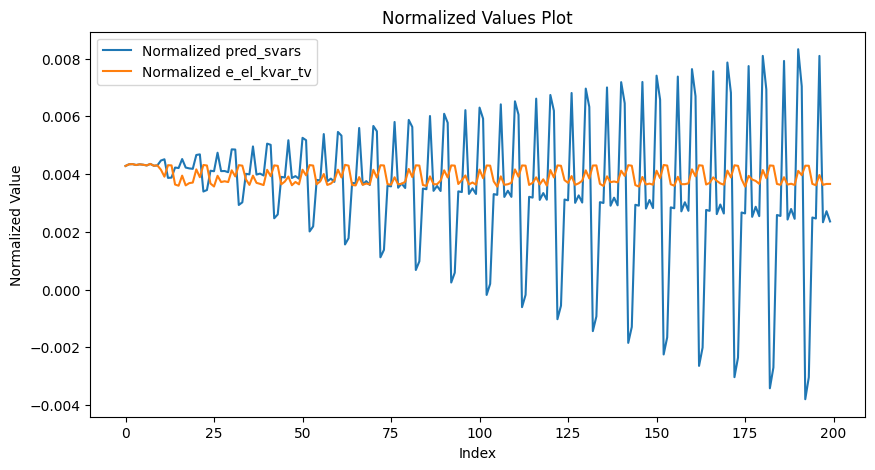

In [99]:
normalized_pred_svars = NICE_network.Normalize(pred_svars[:, ntrain[0:10]], prm_var)[:,:,0].reshape(-1,1)
normalized_e_el_kvar_tv = NICE_network.Normalize(e_el_kvar_tv[:, ntrain[0:10]], prm_var)[:,:,0].reshape(-1,1)

# Plot the normalized tensors
plt.figure(figsize=(10, 5))
plt.plot(normalized_pred_svars.detach().numpy(), label='Normalized pred_svars')
plt.plot(normalized_e_el_kvar_tv.detach().numpy(), label='Normalized e_el_kvar_tv')
plt.xlabel('Index')
plt.ylabel('Normalized Value')
plt.title('Normalized Values Plot')
plt.legend()
plt.show()

In [150]:
# Training loop
for epoch in range(1, Nepochs):
    # Reset gradients
    optimizer.zero_grad()
    # Make predictions
    pred_svars, pred_diss = NICE_network.integrate(dstrain_tv, torch.tensor(e_el_kvar_t_tv[0,:]), t, np.hstack((ntrain, nval)))

    # Compute training loss
    training_loss_svars = MSE(NICE_network.Normalize(pred_svars[:, ntrain],prm_var),
                               NICE_network.Normalize(e_el_kvar_tv[:, ntrain], prm_var))
    norm_d = torch.max(torch.abs(pred_diss)).detach()
    training_loss_dissipation = MSE(NICE_network.relu(-pred_diss[:, ntrain]) / norm_d,
                                    pred_diss[:, ntrain].detach() * 0)

    # L2 regularization term
    l_reg = torch.tensor(0., requires_grad=True)
    for name, param in NICE_network.named_parameters():
        if 'weight' in name:
            l_reg = l_reg + pow(param, 2).sum()

    # Compute the overall training loss
    training_loss = (torch.mean(training_loss_svars)
                     + torch.mean(training_loss_dissipation)
                     + w_reg * l_reg
                     )

    # Backpropagate loss and perform optimizer step
    training_loss.backward()
    optimizer.step()

    # Learning rate scheduler step
    if scheduler.get_last_lr()[0] > 1.e-4:
        scheduler.step()

    # Compute validation loss
    validation_loss_svars = MSE(NICE_network.Normalize(pred_svars[:, nval], prm_var),
                                 NICE_network.Normalize(e_el_kvar_tv[:, nval], prm_var))
    validation_loss_dissipation = MSE(NICE_network.relu(-pred_diss[:, nval]) / norm_d,
                                      pred_diss[:, nval].detach() * 0)
    validation_loss = torch.mean(validation_loss_svars) + torch.mean(validation_loss_dissipation)

    # Store loss values
    training_loss_value = training_loss.item()
    validation_loss_value = validation_loss.item()
    training_loss_hist.append(training_loss_value)
    validation_loss_value_hist.append(validation_loss_value)

    # Print loss information
    if not epoch % verbose_frequency:
        print(f"Epoch: {epoch}"
              + f" | training loss: {training_loss_value:.4e}"
              + f" | validation loss: {validation_loss_value:.4e}")

    # Check for early stopping criterion
    early_stopping(validation_loss_value, NICE_network)
    if early_stopping.early_stop:
        print("Early stopping")
        NICE_network.load_state_dict(torch.load(checkpoint_path))
        break

KeyboardInterrupt: 

In [59]:
pred_svars.shape

torch.Size([20, 4200, 7])

In [60]:
#output_test = [dkappa_damage_dt_test,energy_dt_test,stress_dt_f_test,disipat_dt_test]
pred_svars, pred_diss = NICE_network.integrate(dstrain_tv, torch.tensor(e_el_kvar_t_tv[0,:]), t, np.hstack((ntrain, nval)))

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [67]:
pred_svars[:, ntrain].reshape(-1, 3).detach().numpy()[:,1]

array([-4.70711666e-04,  9.74605279e-01, -2.02471203e-03, ...,
        9.64293660e-01, -4.50558049e-03, -7.11282478e+00])

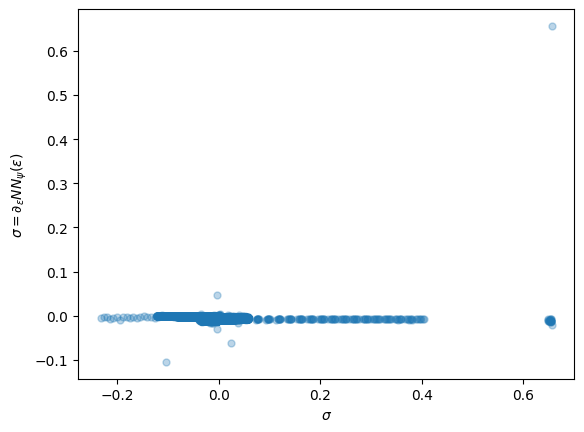

In [72]:
plt.plot(pred_svars[:, ntrain].reshape(-1, 7).detach().numpy()[:,0],e_el_kvar_tv[:, ntrain].reshape(-1, 7).detach().numpy()[:,0], alpha=0.3,linewidth=0, marker='o',markersize=5)
plt.xlabel("$\sigma$");plt.ylabel("$\sigma=\partial_{\\varepsilon} NN_{\psi}(\\varepsilon)$");plt.show()

In [271]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy import interpolate
from torchdiffeq import odeint

# Dictionary of activation functions
activations = {'relu': torch.nn.ReLU(),
               'sigmoid': torch.nn.Sigmoid(),
               'elu': torch.nn.ELU(),
               'tanh': torch.nn.Tanh(),
               'gelu': torch.nn.GELU(),
               'silu': torch.nn.SiLU(),
               'softplus': torch.nn.Softplus(beta=1, threshold=20),
               'leaky_relu': torch.nn.LeakyReLU()}


class NICE_reduced1(torch.nn.Module):
    '''
    Neural Integration for Constitutive Equations (NICE) - Reduced Version
    '''

    def __init__(self, params_evolution, number_IC, norm_params, dim=2, dtype=torch.float32):
        super(NICE_reduced1, self).__init__()

        # Set data type and dimension
        self.dtype,self.dim = dtype , dim

        # Unpack normalization parameters
        self.prm_de,self.prm_var, self.prm_dt = norm_params
        
        # Initialize solver and neural networks for evolution and energy
        self.solver = None
        self.NeuralNetEvolution = self.constructor(params_evolution)#NNf_params = [2*dim,dim,[6*(2*dim),6*(2*dim),6*(2*dim),],'gelu']
        self.relu = torch.nn.ReLU()

        # Initialize elastic strain parameter and normalization factor
        self.inference = None

    def constructor(self, params):
        i_dim, o_dim, h_dim, act = params
        dim = i_dim
        layers = torch.nn.Sequential()
        for hdim in h_dim:
            layers.append(torch.nn.Linear(dim, hdim, dtype=self.dtype))
            layers.append(activations[act])
            dim = hdim
        layers.append(torch.nn.Linear(dim, o_dim, dtype=self.dtype))
        return layers

    def Normalize(self, inputs, prm):
        return torch.divide(torch.add(inputs, -prm[1]), prm[0])

    def DeNormalize(self, outputs, prm):
        return torch.add(torch.multiply(outputs, prm[0]), prm[1])

    def forward(self, t, y):
        # Extract elastic strain and normalize
        uel_k = y[:, :self.dim]; nel_k = self.Normalize(uel_k, self.prm_var)

        # Determine total strain rate (ueps_dot)
        if self.inference == False:
            if t > 1.:
                ueps_dot = self.de[-1]
            else:
                ueps_dot = self.de[int(t / self.prm_dt)]
        else:
            # Interpolate external data for inference
            ueps_dot = torch.zeros((len(self.idx), 2))
            for i in range(len(self.idx)):
                ueps_dot[i, 0] = torch.from_numpy(self.interp_dotev[self.idx[i]](t.detach().numpy()))
                ueps_dot[i, 1] = torch.from_numpy(self.interp_dotes[self.idx[i]](t.detach().numpy()))
        
        neps_dot = self.Normalize(ueps_dot, self.prm_de).detach()
        
        # Feed-forward neural network for evolution
        nodes = self.NeuralNetEvolution(torch.cat((neps_dot, nel_k), -1))##NNf_params = [2*dim,dim,[6*(2*dim),6*(2*dim),6*(2*dim),],'gelu']
        node_el_k = nodes[:, :self.dim];uode_el_k = self.DeNormalize(node_el_k, self.prm_var)# De-normalize the output

        return uode_el_k

    def integrate(self, de, y0, t, idx):
        self.de = de# give stain all alomg the history path, its shape is [40, 24, 2] 40 points for each path X 24 path x strain has two comps.
        self.idx = idx
        K = 70.e+6;G = 60.e+6;y0 = torch.stack((y0[:,0]/K, y0[:,1]/(3*G)), dim=-1)
        y_ = odeint(self, y0, t, method=self.solver, options={"step_size": self.step_size})#forward(self, t, y): deps = self.de[t] (its shape is [40, 24, 2]) return NNEV(deps, e_el), -1)) with dim(:,dim=2)
        #t = tensor([0.0000, 0.0250, 0.0500, *******************,2.4750])@ number is 100
        uel_k = y_[:, :, :self.dim]; nel_k = self.Normalize(uel_k, self.prm_var);nel=nel_k
        
        n_de = self.Normalize(self.de, self.prm_de)

        # Feed-forward neural network for evolution
        nodes = self.NeuralNetEvolution(torch.cat((n_de, uel_k), -1))
        node_el_k = nodes[:, :, :self.dim];uode_el_k = self.DeNormalize(node_el_k, self.prm_var)

        # Calculate the dissipation rate
        uode_pl = self.de - uode_el_k

        return y_, torch.einsum('ijk,ijk->ij', nel[1:], uode_pl[:-1])#check dissipation

    def init_interp(self, args, t):
        # Initialize interpolation for external data
        self.x = np.arange(args.shape[1])
        self.interp_dotev = []
        self.interp_dotes = []
        for i in range(len(self.x)):
            f = interpolate.interp1d(t, args[:, i, 0], fill_value="extrapolate", kind="previous")
            g = interpolate.interp1d(t, args[:, i, 1], fill_value="extrapolate", kind="previous")
            self.interp_dotev.append(f)
            self.interp_dotes.append(g)

    def find_elastic_strain(self, eps_e, eps_e1):
        # Find elastic strain using a root-finding method
        rhs = eps_e.detach() - eps_e1.detach().numpy()
        return rhs.reshape(-1)

In [19]:
np.size(strain_t)

1920

In [17]:
len(strain_t)

960

In [16]:
verbose_frequency = 10# Setting the frequency in epochs for printing loss during training
# Step size for the training process. If set to 20, it reproduces the original results otherwise, set to 1 for faster training.
step_size = 20
device = torch.device('cpu')
corrupted_training_data = False# Boolean flag for adding normally distributed noise to the training dataset
file = './dataset/benchmark1_data_training'
with open(file, 'rb') as f_obj:
    data = pickle.load(f_obj)

[strain_t,strain_tdt,e_el_kvar_t,dt,n_reset] = data#e_el_kvar_t = 3 elastic strain + 4 internal variables

batch_time = n_reset# Setting batch_time equal to n_reset
data_size = n_reset# Setting data_size equal to n_reset
dim = 2# Dimensionality of the data
prm_dt = 1 / data_size# Setting prm_dt as the reciprocal of data_size

dstrain = strain_tdt - strain_t
dstrain/=prm_dt

strain_t = np.reshape(strain_t,(batch_time,-1,dim),order='F')
strain_tdt = np.reshape(strain_tdt,(batch_time,-1,dim),order='F')
dstrain = np.reshape(dstrain,(batch_time,-1,dim),order='F')
e_el_kvar_t = np.reshape(e_el_kvar_t,(batch_time,-1,dim),order='F')

data_size = strain_t.shape[0]
number_IC = strain_t.shape[1]

In [273]:
train_percentage = 0.65# Percentage of data to be used for training
train = int(round(number_IC * train_percentage))# Calculating the number of samples for training, validation, and testing
val = int(round(number_IC * 0.5 * (1. - train_percentage)))
test = val
# Printing information about the data split
print("Number of samples: ", number_IC);print("Training samples: ", train);print("Validation samples: ", val);print("Test samples: ", test);print("Total: ", test + val + train)

Number of samples:  24
Training samples:  16
Validation samples:  4
Test samples:  4
Total:  24


In [274]:
# Creating an array of sequential numbers from 0 to number_IC - 1
n = np.arange(0, number_IC, 1)

# Creating an array of indices and shuffling it
rnd = np.arange(len(n))
np.random.shuffle(rnd)
n = n[rnd]

# Splitting the shuffled indices into training, validation, and test sets
ntrain = n[:train]
cut = len(ntrain)
nval = n[train:]
ntrainval = np.hstack((ntrain, nval))
ntest = n[train + val:]

# Shuffling the indices for training and validation combined set
rnd = np.arange(len(ntrainval))
np.random.shuffle(rnd)

# Splitting the shuffled indices for training and validation sets
ntrain = rnd[:train]
nval = rnd[val:]

# Slicing the stress data into training-validation and test sets
strain_t_tv, strain_t_test = slice_data(strain_t, ntrainval, ntest)
strain_tdt_tv, strain_tdt_test = slice_data(strain_tdt, ntrainval, ntest)
dstrain_tv, dstrain_test = slice_data(dstrain, ntrainval, ntest)
e_el_kvar_t_tv, e_el_kvar_t_test = slice_data(e_el_kvar_t, ntrainval, ntest)

prm_de = get_params(dstrain_tv).to(device)
prm_var = get_params(e_el_kvar_t_tv).to(device)

In [275]:
strain_tdt_tv

array([[[1.42857143e-05, 1.00000000e-06],
        [3.14285714e-05, 1.00000000e-06],
        [2.67142857e-05, 0.00000000e+00],
        ...,
        [2.00000000e-05, 1.00000000e-06],
        [8.57142857e-06, 1.00000000e-06],
        [2.64769525e-05, 9.13387449e-07]],

       [[1.42857143e-05, 2.00000000e-06],
        [3.14285714e-05, 2.00000000e-06],
        [2.77142857e-05, 0.00000000e+00],
        ...,
        [2.00000000e-05, 2.00000000e-06],
        [8.57142857e-06, 2.00000000e-06],
        [2.72080623e-05, 1.83965800e-06]],

       [[1.42857143e-05, 3.00000000e-06],
        [3.14285714e-05, 3.00000000e-06],
        [2.87142857e-05, 0.00000000e+00],
        ...,
        [2.00000000e-05, 3.00000000e-06],
        [8.57142857e-06, 3.00000000e-06],
        [2.79053364e-05, 2.77974191e-06]],

       ...,

       [[1.42857143e-05, 1.70000000e-05],
        [3.14285714e-05, 1.30000000e-05],
        [2.77142857e-05, 0.00000000e+00],
        ...,
        [2.00000000e-05, 1.60000000e-05],
     

In [276]:
import torch
import argparse
# Parse command-line arguments
parser = argparse.ArgumentParser(description='Set device.')
parser.add_argument('--device', type=str, default='cpu', choices=['cpu', 'cuda'], help='Device to use (default: cpu)')
args = parser.parse_args()
# Set the device to CPU or CUDA based on the argument, but default to CPU
device = torch.device(args.device if args.device == 'cpu' or torch.cuda.is_available() else 'cpu')
# Print the device being used
print("Using device:", device)

usage: ipykernel_launcher.py [-h] [--device {cpu,cuda}]
ipykernel_launcher.py: error: unrecognized arguments: --f=c:\Users\osama\AppData\Roaming\jupyter\runtime\kernel-v2-85108LWaYs3uDU3QI.json


SystemExit: 2

c:\Users\osama\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3377: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [277]:
dim=2

In [247]:
dtype=torch.float64
NNf_params = [2*dim,dim,[6*(2*dim),6*(2*dim),6*(2*dim),],'gelu']
norm_params = [prm_de,prm_var,prm_dt]
nsvars = 1
number_IC = len(ntrainval)
NICE_network = NICE_reduced1(NNf_params,number_IC,norm_params,dim,dtype).to(device)
NICE_network.to(torch.double)

NameError: name 'NICE_reduced1' is not defined

In [279]:
prm_dt = 1 / data_size# Calculating the time step for the simulation
t = torch.arange(0, 1.0, prm_dt)# Creating a time array from 0 to 1 with the calculated time step

# Converting stress and incremental strain data to torch tensors and moving them to the specified device
e_el_kvar_tv = torch.from_numpy(np.float64(e_el_kvar_t_tv)).to(device)
dstrain_tv = torch.from_numpy(np.float64(dstrain_tv)).to(device)

# Converting test set stress and incremental strain data to torch tensors and moving them to the specified device
e_el_kvar_test = torch.from_numpy(np.float64(e_el_kvar_t_test)).to(device)
dstrain_test = torch.from_numpy(np.float64(dstrain_test)).to(device)

In [280]:
NICE_network.solver = "midpoint"# Setting the solver type for the NICE network
NICE_network.scheme = "forward"# Setting the integration scheme for the NICE network
NICE_network.step_size = prm_dt / step_size# Setting the step size for the integration in the NICE network
NICE_network.init_interp(dstrain_tv, t)# Initializing the interpolation function for incremental strain and time in the NICE network
NICE_network.inference = False# Turning off the inference mode in the NICE network

learningRate = 1e-2# Setting the learning rate for the optimizer
optimizer = torch.optim.Adam(NICE_network.parameters(), lr=learningRate)# Initializing the Adam optimizer with the NICE network parameters
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)# Setting up a learning rate scheduler to adjust the learning rate during training
w_reg = 1.e-5# L2 penalty weight for regularization
Nepochs = 1000000# Number of training epochs
MSE = torch.nn.MSELoss()# Mean Squared Error (MSE) loss function
checkpoint_path = './checkpoints/checkpoint.pt'# Setting up early stopping with specified criteria
early_stopping = EarlyStopping(patience=2000, delta=1.e-9, verbose=False, path=checkpoint_path)

# Lists for storing training and validation loss history
training_loss_hist = []
validation_loss_value_hist = []

In [246]:
dstrain_tv.shape

torch.Size([20, 4200, 3])

In [244]:
# Training loop
for epoch in range(1, Nepochs):
    # Reset gradients
    optimizer.zero_grad()
    # Make predictions
    pred_svars, pred_diss = NICE_network.integrate(dstrain_tv, stress_tv[0], t, np.hstack((ntrain, nval)))

    # Compute training loss
    training_loss_svars = MSE(NICE_network.Normalize(pred_svars[:, ntrain],prm_var),
                               NICE_network.Normalize(e_el_kvar_tv[:, ntrain], prm_var))
    norm_d = torch.max(torch.abs(pred_diss)).detach()
    training_loss_dissipation = MSE(NICE_network.relu(-pred_diss[:, ntrain]) / norm_d,
                                    pred_diss[:, ntrain].detach() * 0)

    # L2 regularization term
    l_reg = torch.tensor(0., requires_grad=True)
    for name, param in NICE_network.named_parameters():
        if 'weight' in name:
            l_reg = l_reg + pow(param, 2).sum()

    # Compute the overall training loss
    training_loss = (torch.mean(training_loss_svars)
                     + torch.mean(training_loss_dissipation)
                     + w_reg * l_reg
                     )

    # Backpropagate loss and perform optimizer step
    training_loss.backward()
    optimizer.step()

    # Learning rate scheduler step
    if scheduler.get_last_lr()[0] > 1.e-4:
        scheduler.step()

    # Compute validation loss
    validation_loss_svars = MSE(NICE_network.Normalize(pred_svars[:, nval], prm_var),
                                 NICE_network.Normalize(e_el_kvar_tv[:, nval], prm_var))
    validation_loss_dissipation = MSE(NICE_network.relu(-pred_diss[:, nval]) / norm_d,
                                      pred_diss[:, nval].detach() * 0)
    validation_loss = torch.mean(validation_loss_svars) + torch.mean(validation_loss_dissipation)

    # Store loss values
    training_loss_value = training_loss.item()
    validation_loss_value = validation_loss.item()
    training_loss_hist.append(training_loss_value)
    validation_loss_value_hist.append(validation_loss_value)

    # Print loss information
    if not epoch % verbose_frequency:
        print(f"Epoch: {epoch}"
              + f" | training loss: {training_loss_value:.4e}"
              + f" | validation loss: {validation_loss_value:.4e}")

    # Check for early stopping criterion
    early_stopping(validation_loss_value, NICE_network)
    if early_stopping.early_stop:
        print("Early stopping")
        NICE_network.load_state_dict(torch.load(checkpoint_path))
        break

RuntimeError: The size of tensor a (3) must match the size of tensor b (7) at non-singleton dimension 1